# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import tueplots.constants.color as tpc
from tueplots import cycler
import math

import scipy.integrate
import scipy

from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK
import os

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from helpers import days_to_date
from ridgeline_plot import ridgeline_plot

def full_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="full"))
def half_fig(nrows=1, ncols=1):
    plt.rcParams.update(bundles.icml2022(column="half"))
def set_dpi(dpi):
    plt.rcParams.update({"figure.dpi": dpi})

plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update(cycler.cycler(color=tp.constants.color.palettes.tue_plot))
# plt.rcParams.update({"figure.dpi": 400})
# plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = True
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"
FIGURE_FOLDER = "../paper/fig"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
# METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRICS = ["wind"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/']


In [3]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', '/Users/david/Uni/WS2324/Data-Literacy/DataLiteracyProject/data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']


In [4]:
# print(df.dtypes)
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind            float64
eor_wind               object
dtype: object


## Preprocessing

First, we need to assess how good our data integrity is. This includes accounting for missing values (NaNs) and even implicitly missing data, that is, missing data that is not represented by NaN but simply is not present at all. Then, we need to deal with outliers.

In [5]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs
# a bit more than one year across all years is missing (~ 58000 days)
nans_by_year = wind_df[wind_df["FF_10_wind"].isna()].groupby("year")["STATIONS_ID"].count().reset_index() 
nans_by_year.columns = ["year", "#NaNs"]
# group by year and count NaNs
print(nans_by_year)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
# simply drop rows with missing values
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]
rest_df = wind_df.groupby("year")["FF_10_wind"].count().reset_index()
rest_df.columns = ["year", "count"]
# compute the completeness of each year by calculating min(1, #measurements / 24 * 6 * 365.25)
# the denominator corresponds to the number of measurements each year _should_ contain
rest_df["count"] /= 24 * 6 * 365.25
rest_df["count"] = rest_df["count"].clip(0, 1)
print(rest_df)
# The year 1996 has almost not measurements and years 1997 and 1998 have between ~15% and ~16% missing
print(f"Integrity (all): {rest_df['count'].mean()}")
# The span of 1999-2019 (exclusive) has 99% completeness
print(f"Integrity (1999-2019): {rest_df[(rest_df['year'] > 1998) & (rest_df['year'] <= 2018)]['count'].mean()}")

    year  #NaNs
0   2000      4
1   2001     10
2   2002     30
3   2003      5
4   2007      8
5   2009    217
6   2013   1578
7   2014     62
8   2015    196
9   2016   1056
10  2017   1040
11  2018   4868
12  2019  46074
13  2020    950
14  2021   1819
15  2022    277
#NaNs: 58194
    year     count
0   1996  0.029641
1   1997  0.848334
2   1998  0.837953
3   1999  0.997433
4   2000  1.000000
5   2001  0.998403
6   2002  0.998023
7   2003  0.994714
8   2004  0.999924
9   2005  0.998992
10  2006  0.998042
11  2007  0.999163
12  2008  1.000000
13  2009  0.995190
14  2010  0.999316
15  2011  0.999316
16  2012  1.000000
17  2013  0.969313
18  2014  0.998137
19  2015  0.995589
20  2016  0.981976
21  2017  0.979542
22  2018  0.906761
23  2019  0.123317
24  2020  0.983991
25  2021  0.906229
26  2022  0.994049
Integrity (all): 0.9086425386524255
Integrity (1999-2019): 0.9904916723705226


Now, we turn to detecting and deleting outliers. These very well may be valid measurements but the distort our Weibull distrubtion estimations and since we are not interested in storms but rather normal wind speeds useable by wind turbines, this is not a huge loss.

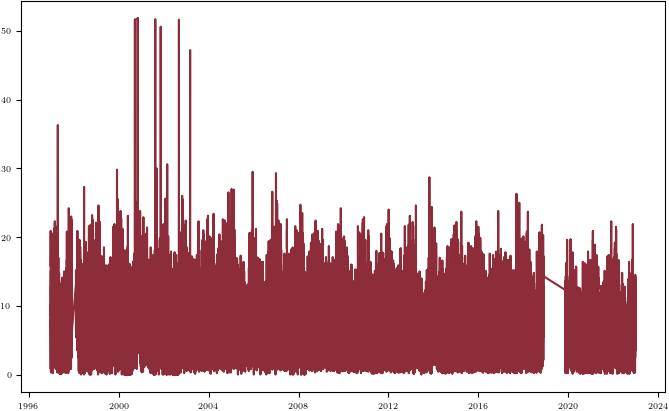

In [6]:
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

1158


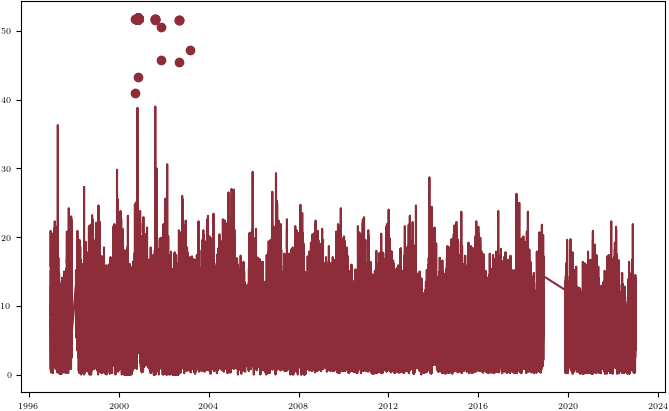

In [7]:
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 8
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold])
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[zscores <= threshold])
print(wind_df[zscores > threshold].STATIONS_ID.count())
# We only keep those data points that have a z-score of < 8. In the next figure we can see that not too many data points exceed this threshold.
wind_df = wind_df[zscores < 8]

## Explorative Data Analysis

To get a feel for the data, we now perform some explorative data analysis.

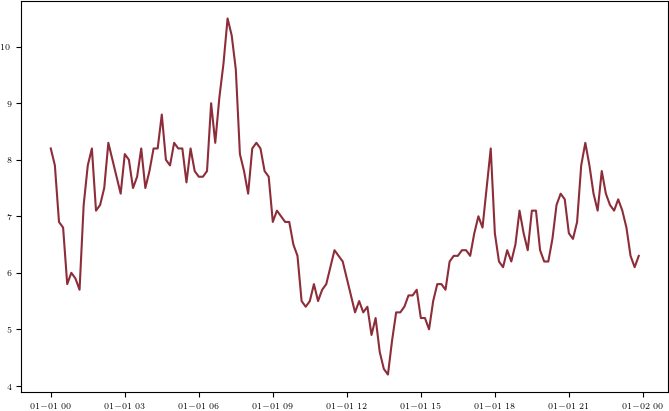

In [8]:
# First, we plot the wind speeds on some arbitrarly chosen day: 1.1.2022
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


## Heat-map

For visualising the behaviour of the wind across each day for one year, we use a heat-map that aggregates the wind speeds for each day. I can be observed that during the summer, the wind speeds are generally lower and start pick up when approaching autumn and winter.

/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_76597/823536238.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


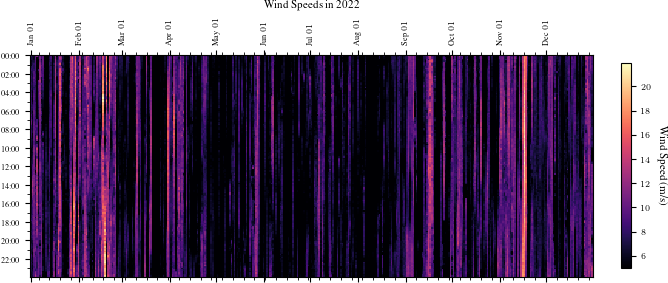

In [9]:
wind_df_2022 = wind_df[wind_df["MESS_DATUM"].dt.year == 2022].copy()
wind_df_2022["Day"] = wind_df_2022["MESS_DATUM"].dt.date
wind_df_2022["Time"] = wind_df_2022["MESS_DATUM"].dt.time

pivot_table_2022 = pd.pivot_table(
    wind_df_2022, values=("FF_10_wind"), index=["Time"], columns=["Day"], aggfunc="mean"
).fillna(0)

fig, ax = plt.subplots()
im = ax.matshow(pivot_table_2022, cmap="magma", vmin=5)

ax.set_yticks(np.arange(len(pivot_table_2022.index))[::12])
ax.set_yticks(np.arange(len(pivot_table_2022))[::6], minor=True)
ax.set_yticklabels([time.strftime("%H:%M") for time in pivot_table_2022.index[::12]])

ax.xaxis.set_major_locator(mdt.MonthLocator(interval=1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_minor_locator(
    mdt.WeekdayLocator(interval=1)
)
date_form = mdt.DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
# ax.grid(which="major", axis="x", linestyle="--", linewidth="0.5", color="gray")
# ax.grid(which="major", axis="y", linestyle="--", linewidth="0.5", color="gray")

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.5)
cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

ax.set_title("Wind Speeds in 2022")
plt.show()

Text(0.5, 0.98, 'Wind Speeds 2015-2022')

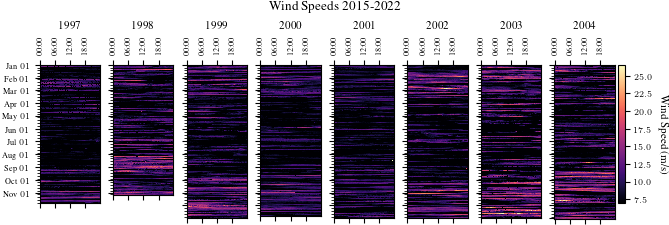

In [10]:
fig, axs = plt.subplots(1, 8, sharex=True, sharey=False)
# fig.suptitle("Wind Speeds in the years 2015-2022")

for i, year in enumerate(range(1997, 2005)):
    ax = axs[i]
    # ax.set_anchor("N")
    mask = wind_df["MESS_DATUM"].dt.year == year
    wind_df_year = wind_df[mask].copy()
    wind_df_year.fillna(0, inplace=True)

    wind_df_year["Day"] = wind_df_year["MESS_DATUM"].dt.date
    wind_df_year["Time"] = wind_df_year["MESS_DATUM"].dt.time

    pivot_table = pd.pivot_table(
        wind_df_year, values=("FF_10_wind"), index=["Day"], columns=["Time"], aggfunc="mean", fill_value=0
    )

    Daystrings = [date.strftime("%d %b") for date in pivot_table.index.values]
    TimeStrings = [time.strftime("%H:%M") for time in pivot_table.columns]

    im = ax.matshow(pivot_table, cmap="magma", vmin=7)

    ax.set_xticks(np.arange(len(pivot_table.columns))[:: (6 * 6)])
    ax.set_xticklabels(TimeStrings[:: (6 * 6)], rotation=90)
    ax.yaxis.set_major_locator(
        mdt.MonthLocator(interval=1)
    )
    ax.yaxis.set_minor_locator(
        mdt.WeekdayLocator(interval=1)
    )
    if i == 0:
        ax.yaxis.set_major_formatter(date_form)
    else:
        ax.set_yticklabels([])

    if i == 7:
        cbar = fig.colorbar(im, ax=ax, shrink=0.4, location="right", anchor=(1.0, 1.0))
        cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

    ax.set_title(year)

for ax in axs:
    ax.set_anchor("N")
fig.suptitle("Wind Speeds 2015-2022")

By plotting the monthly mean fluctuation (i.e. the mean difference of min. and max. speeds) of the wind speed, we can see that, starting in 2019, the fluctuation have become noticably less.

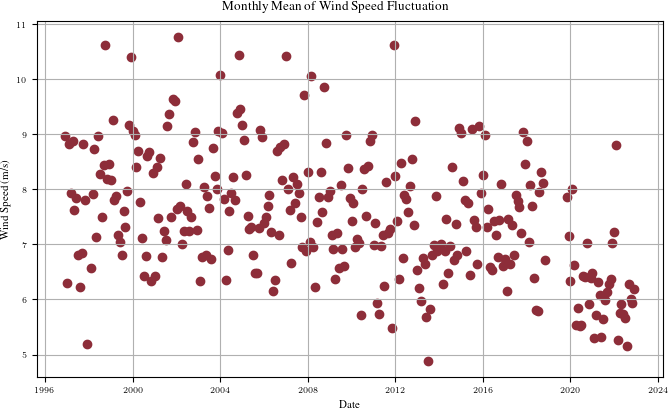

In [11]:
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.scatter(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

Text(0.5, 0.98, 'Monthly Mean of Wind Speed Fluctuations')

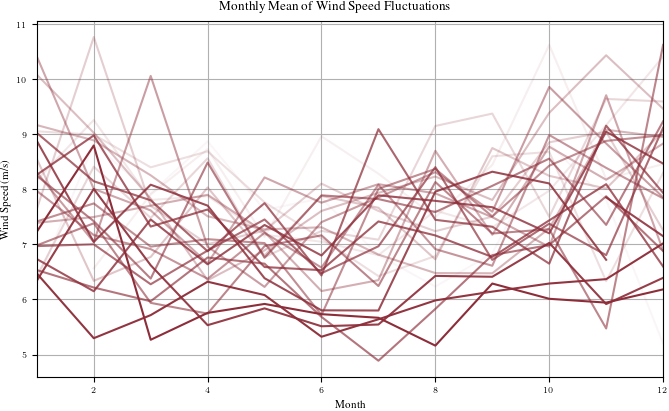

In [12]:
fig, axs = plt.subplots(1, 1)

for year, year_month_df in wind_df_mean_diff.groupby("year"):
    alpha = (year - 1996) / (2022 - 1996)
    axs.plot(year_month_df["month"], year_month_df["diff"], color=tp.constants.color.rgb.tue_red, alpha=alpha)
# sns.boxplot(data=wind_df_agg_yr, x=wind_df_agg_yr.index.values, y="diff")

axs.set_ylabel("Wind Speed (m/s)")
axs.set_xlabel("Month")
axs.set_xlim((1, 12))
axs.grid(which="major")
fig.suptitle("Monthly Mean of Wind Speed Fluctuations")
# wind_df_mean_diff.groupby("year")["diff"].plot(kind="kde", ax=axs[1])

Text(0.5, 0, 'Wind Speeds (m/s)')

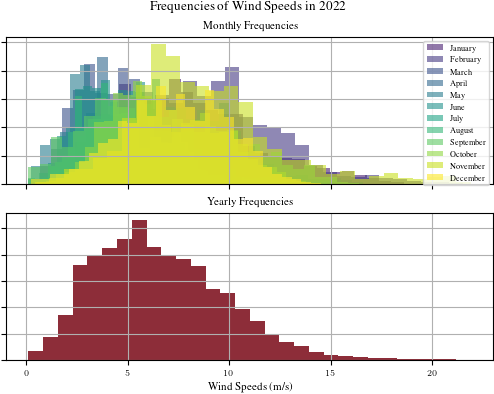

In [13]:
plt.rcParams.update(bundles.icml2022(nrows=2, ncols=1))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
# Create a list of colors for the colormap (here, we use a smooth transition from blue to red to blue)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

fig.suptitle("Frequencies of Wind Speeds in 2022")
wind_df_2022["month"] = wind_df_2022["MESS_DATUM"].dt.month
for year, year_month_df in wind_df_2022.groupby("month"):
    year_month_df.hist(column="FF_10_wind", bins=30, ax=ax1, alpha=0.6, label=dt.datetime(2022, year, 1).strftime("%B"), color=colors[year])
# wind_df_2022[wind_df_2022["MESS_DATUM"].dt.month == 6].hist(column="FF_10_wind", bins=20, ax=ax)
ax1.set_title("")
ax1.set_yticklabels([])
# ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_title("Monthly Frequencies")
ax1.legend(loc="upper right")

wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax2)
ax2.set_title("Yearly Frequencies")
ax2.set_yticklabels([])
ax2.set_xlabel("Wind Speeds (m/s)")

Using the `Weibull` class and the _maximum-likelihood method_, we use the monthly or the yearly data to estimate the parameters of a Weibull distribution and compare the estimations to the empirical distribution (frequencies). We can observe that the Weibull distribution quite accurately captures "normal" wind speeds.

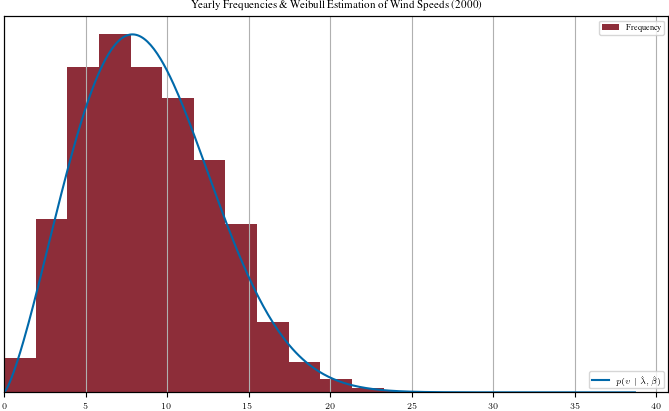

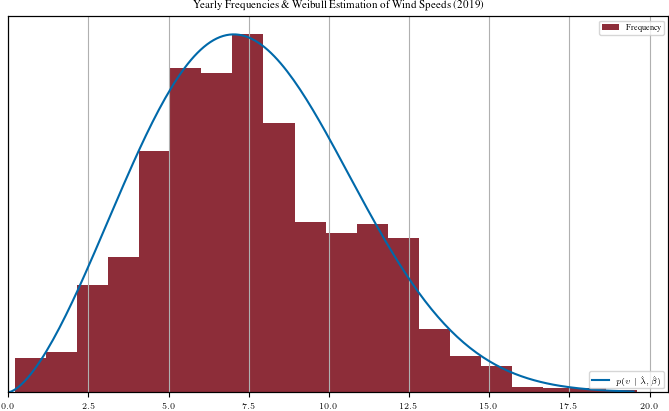

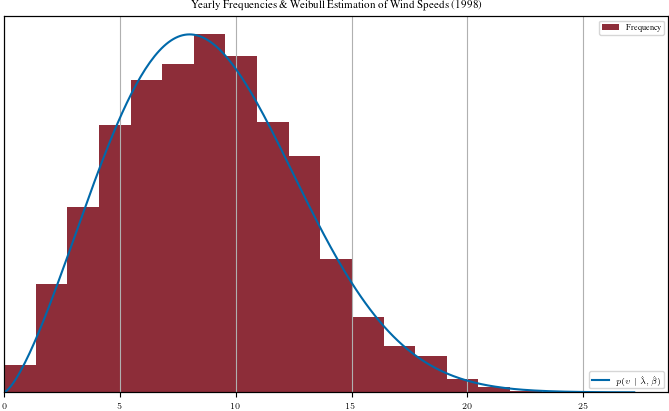

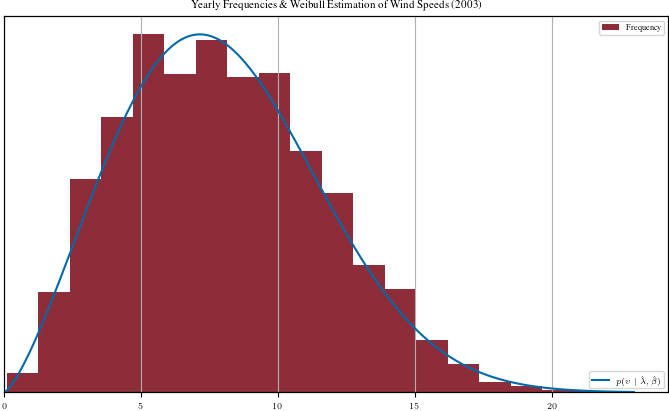

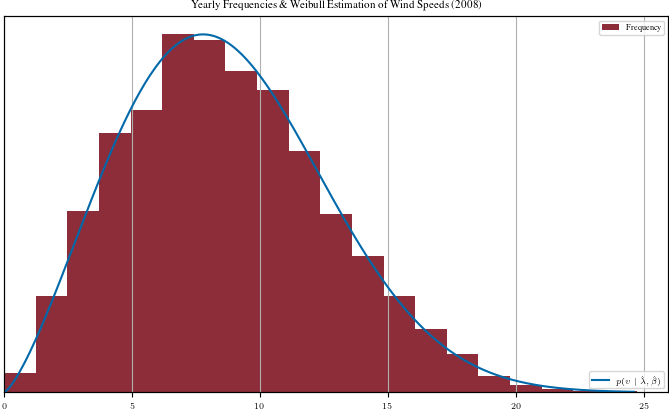

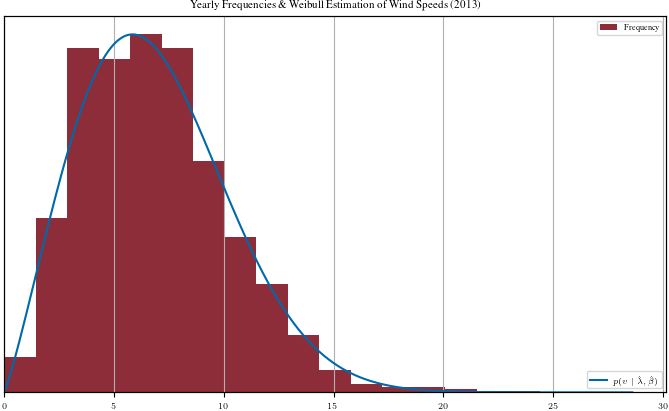

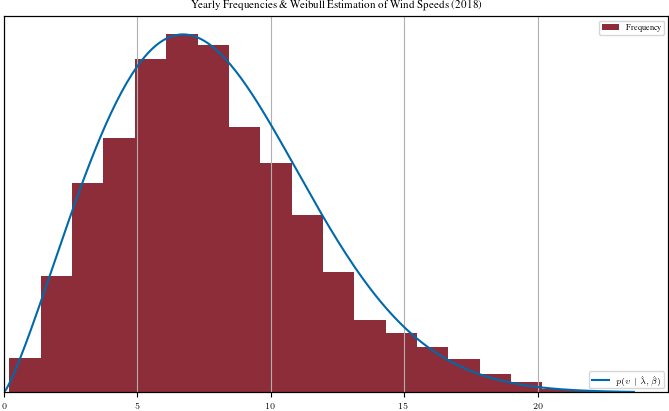

In [14]:
def plot_year(year):
    fig, ax = plt.subplots()
    year_df = wind_df[wind_df["MESS_DATUM"].dt.year == year]
    year_df_wind_mean = year_df["FF_10_wind"].mean()
    Y = year_df["FF_10_wind"].dropna().to_numpy()
    
    weibull = Weibull.estimate(Y)
    X = np.arange(0, np.max(Y), 0.1)

    ax1 = ax.twinx()
    ax1.plot(X, weibull.pdf(X), color=tp.constants.color.rgb.tue_blue, label=r"$p(v \mid \hat{\lambda}, \hat{\beta})$")
    ax1.set_ylim(0)
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax1.legend(loc="lower right")


    year_df.hist(column="FF_10_wind", bins=20, ax=ax, color=tp.constants.color.rgb.tue_red, label="Frequency")
    ax.set_title("")
    ax.set_xlim(0)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.legend(loc="upper right")
    ax.set_title(f"Yearly Frequencies \& Weibull Estimation of Wind Speeds ({year})")

# year with invalid measurements
plt.rcParams.update(bundles.icml2022(column="full"))
plot_year(2000)
plot_year(2019)

years = range(1998, 2023, 5)
for year in years:
    plot_year(year)
plt.show()

Using the monthly Weibull distributions, we can again find the pattern of lower wind speeds in the summer and higher wind speeds in the winter and spring.

Text(0, 0.5, 'p(v $\\mid \\hat{\\lambda}, \\hat{\\beta}$)')

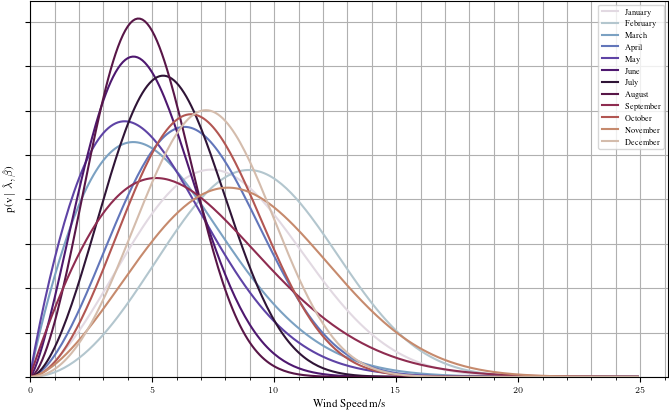

In [15]:
fig, ax = plt.subplots(1, 1)

for i, (month, month_df) in enumerate(wind_df_2022.groupby("month")):
    Y = month_df["FF_10_wind"].dropna().to_numpy()
    X = np.arange(0, 25, 0.1)
    weibull = Weibull.estimate(Y)
    color = plt.cm.twilight(i / 12)
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2022, month, 1).strftime("%B"), color=color)
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed m/s")
ax.set_ylabel(r"p(v $\mid \hat{\lambda}, \hat{\beta}$)")

We now estimate all monthly and yearly Weibull distributions.

In [16]:

wind_year_dists = []
for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().copy().to_numpy()
    weibull = Weibull.estimate(Y)
    wind_year_dists.append([year, Y, weibull])
wind_year_dists = pd.DataFrame(wind_year_dists, columns=["year", "data", "weibull"])
wind_year_dists

,year,data,weibull
0,1996,"[15.8, 16.2, 16.6, 16.0, 16.3, 16.3, 16.8, 9.4...","Weibull distr for lambda=10.901997394939055, ..."
1,1997,"[7.9, 8.7, 8.8, 8.9, 8.9, 8.8, 9.2, 9.4, 9.2, ...","Weibull distr for lambda=8.861603858938173, b..."
2,1998,"[13.1, 12.0, 13.0, 13.5, 13.3, 13.3, 14.1, 14....","Weibull distr for lambda=10.005245575801538, ..."
3,1999,"[11.3, 11.8, 12.0, 12.0, 12.3, 11.9, 12.5, 12....","Weibull distr for lambda=9.7201764898477, bet..."
4,2000,"[8.4, 7.6, 8.7, 7.6, 8.8, 8.1, 7.7, 9.4, 8.3, ...","Weibull distr for lambda=10.025728428151126, ..."
5,2001,"[13.7, 14.1, 14.8, 15.0, 15.3, 15.2, 15.5, 15....","Weibull distr for lambda=9.349950169543918, b..."
6,2002,"[7.6, 7.9, 7.3, 6.1, 5.6, 5.1, 4.4, 4.9, 7.7, ...","Weibull distr for lambda=9.71885946132631, be..."
7,2003,"[12.4, 12.4, 12.6, 12.5, 12.2, 12.0, 12.3, 11....","Weibull distr for lambda=9.0387494296538, bet..."
8,2004,"[7.6, 8.1, 7.6, 8.3, 7.9, 7.9, 7.7, 7.5, 7.3, ...","Weibull distr for lambda=9.750622581700258, b..."
9,2005,"[3.4, 4.0, 4.6, 4.8, 4.9, 4.6, 4.7, 5.6, 5.7, ...","Weibull distr for lambda=9.730091474253818, b..."


Visualising the yearly distributions, we can observe that the distributions have drastically changed starting in 2019. They have a shorter tail (less mass for high wind speeds) and are there much more concentrated. Also, the mean has shifted noticably. We take this as evidence and the fact that 2019 is missing almost all its values, that the measurement process has somehow been altered. Thereby, the data after 2019 is considered as incompatible with the previous.

Text(0, 0.5, '$\\textrm{p}(\\textrm{v} \\mid \\hat{\\lambda}, \\hat{\\beta})$')

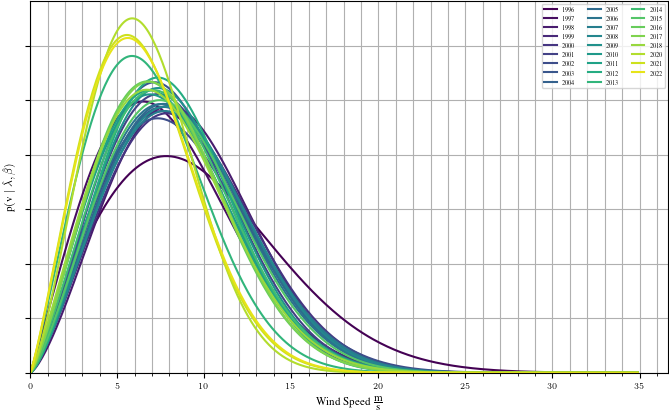

In [17]:
fig, ax = plt.subplots(1, 1)

X = np.arange(0, 35, 0.1)
Y = []
for i, (year, year_df) in enumerate(wind_year_dists.groupby("year")):
    w = year_df["weibull"].values[0]
    y = w.pdf(X)
    Y.append(y)
    color = plt.cm.viridis(i / wind_year_dists["year"].count())    
    ax.plot(X, y, label=year, color=color)
wind_year_dists["prob"] = Y

ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_ylabel(r"$\textrm{p}(\textrm{v} \mid \hat{\lambda}, \hat{\beta})$")

Using joy/ridgeline plots, we can also observe the same pattern

(0.0, 30.0)

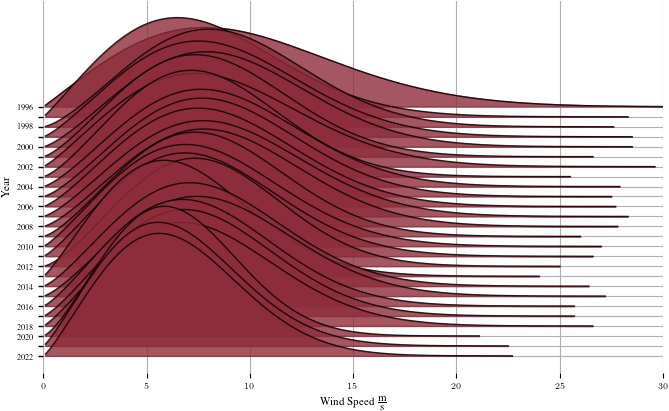

In [18]:
fig, ax = plt.subplots()
labels = [y if y % 2 == 0 else None for y in list(wind_year_dists.year)]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.99, range_threshold=1e-5, alpha_density=0.8, fill_color_density=tp.constants.color.rgb.tue_red, fill_density=True)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.yaxis.set_tick_params(width=1)
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_ylabel("Year")
ax.set_xlim(0, 30)

In [19]:
wind_month_pdfs = []
Y = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    y = year_month_df["FF_10_wind"].to_numpy()
    weibull = Weibull.estimate(y)
    Y.append(weibull.pdf(X))
    wind_month_pdfs.append([year, month, weibull, y, weibull.pdf(X)])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "weibull", "X", "prob"])
wind_month_pdfs.sort_values(by=["year", "month"], inplace=True)
wind_month_pdfs

,year,month,weibull,X,prob
0,1996,12,"Weibull distr for lambda=10.901997394939055, ...","[15.8, 16.2, 16.6, 16.0, 16.3, 16.3, 16.8, 9.4...","[0.0, 0.001456030514843955, 0.0029818205386610..."
1,1997,1,"Weibull distr for lambda=7.957978441723365, b...","[7.9, 8.7, 8.8, 8.9, 8.9, 8.8, 9.2, 9.4, 9.2, ...","[0.0, 0.0019357676475951619, 0.004222819735420..."
2,1997,2,"Weibull distr for lambda=12.056819405208966, ...","[3.2, 3.1, 3.0, 2.9, 2.9, 3.1, 2.7, 3.0, 3.4, ...","[0.0, 9.125924520525411e-06, 4.024622514359949..."
3,1997,3,"Weibull distr for lambda=8.983493404318594, b...","[8.2, 8.5, 8.3, 7.6, 7.6, 7.4, 6.9, 6.8, 6.7, ...","[0.0, 0.0004892605920791548, 0.001292262755260..."
4,1997,4,"Weibull distr for lambda=9.45360763877412, be...","[7.2, 6.8, 6.8, 7.3, 7.2, 6.8, 6.6, 6.4, 6.9, ...","[0.0, 0.00036536376749693905, 0.00099284881526..."
...,...,...,...,...,...
296,2022,8,"Weibull distr for lambda=5.286573366235021, b...","[6.2, 6.4, 6.1, 7.0, 7.4, 8.1, 7.5, 8.4, 8.1, ...","[0.0, 0.0006539187143034846, 0.002089945823990..."
297,2022,9,"Weibull distr for lambda=7.501257710648738, b...","[7.7, 7.2, 7.2, 7.5, 6.9, 7.5, 7.0, 6.9, 7.3, ...","[0.0, 0.004522467486209736, 0.0086509893111239..."
298,2022,10,"Weibull distr for lambda=7.651447270742967, b...","[12.2, 12.8, 11.7, 11.6, 12.4, 12.0, 12.5, 11....","[0.0, 0.00011190128352126835, 0.00040946783646..."
299,2022,11,"Weibull distr for lambda=9.775116693614796, b...","[10.3, 10.2, 9.7, 8.0, 7.4, 7.4, 8.3, 7.6, 7.9...","[0.0, 0.00017454005689609853, 0.00052883879614..."


[ 0.6      1.99375  3.3875   4.78125  6.175    7.56875  8.9625  10.35625
 11.75    13.14375 14.5375  15.93125 17.325   18.71875 20.1125  21.50625
 22.9    ]
[0.01751933 0.04002122 0.05914782 0.07216677 0.0896861  0.0925792
 0.07731006 0.06316602 0.05882637 0.05159362 0.03503866 0.02330553
 0.01751933 0.00996512 0.00755421 0.00208946]


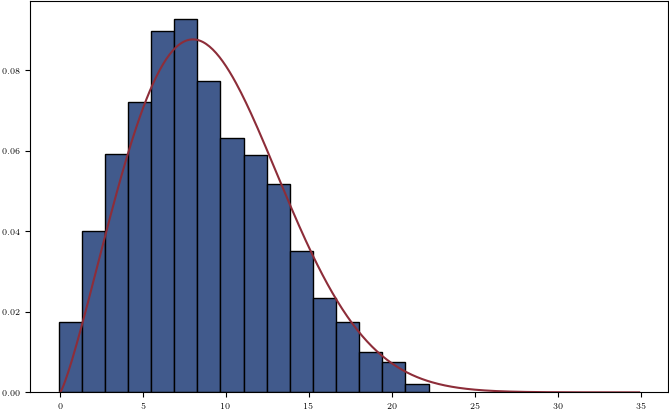

In [20]:
yr_example = wind_month_pdfs[wind_month_pdfs["year"] == 2010].copy()
yr_example.sort_values("month", inplace=True)
counts, bins = np.histogram(yr_example.X.values[11], bins=16, density=True)
hists = list(map(lambda x: np.histogram(x, bins=9, density=True), yr_example.X.values))
print(bins)
print(counts)
plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=1.0, color=tpc.rgb.tue_darkblue, edgecolor='black')
plt.plot(X, yr_example.prob.values[11])

Text(0.5, 0, 'Wind Speed $\\frac{\\mathrm{m}}{\\mathrm{s}}$')

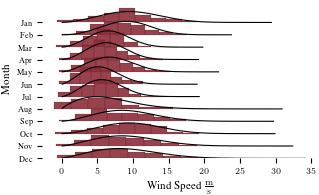

In [21]:
half_fig()
fig, ax = plt.subplots()
labels = [dt.datetime(2010, m, 1).strftime("%b") for m in range(1, 13)]
ridgeline_plot(
    np.tile(X, (12, 1)), yr_example.prob.values[::-1], ax, labels[::-1], hists=hists[::-1],
    linewidth_density=0.8, linewidth_hist=0.1,
    alpha_density=1.0, alpha_hist=0.9,
    fill_density=False, fill_color_density=tpc.rgb.tue_red, fill_color_hist=tpc.rgb.tue_red,
    overlap=0.89, range_threshold=1e-6,
    line_color="black", edge_color="black"
)
ax.set_ylabel("Month")
ax.set_xlabel(r"Wind Speed $\frac{\mathrm{m}}{\mathrm{s}}$")

(0.0, 30.0)

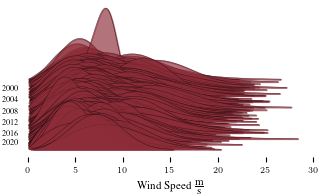

In [22]:
half_fig()
fig, ax = plt.subplots()
labels = [yr if yr % 4 == 0 and mth == 1 else None for yr, mth in zip(list(wind_month_pdfs.year), list(wind_month_pdfs.month))]
ridgeline_plot(np.tile(X, (len(Y), 1)), np.array(Y[::-1]), ax, labels[::-1], overlap=0.999, range_threshold=1e-3, alpha_density=2/3, linewidth_density=0.3, fill_color_density=tp.constants.color.rgb.tue_red, fill_density=True)
ax.yaxis.grid(True, linewidth=0)
ax.yaxis.set_tick_params(width=0)
ax.set_xlabel(r"Wind Speed $\frac{\textrm{m}}{\textrm{s}}$")
ax.set_xlim(0, 30)

## Wind Power Density

Next, we compute the wind power density as the expectation over the yearly and monthly distributions. As the integral is not solvable analytically, we have to restort to numerical methods. For the calculation, we assume a common value for the dry air density at 15 °C of $1.2250$ $\mathrm{kg} / \mathrm{m}^3$.

In [23]:
# https://en.wikipedia.org/wiki/Density_of_air#Dry_air
air_rho = 1.2250
# 120 meter diameter of wind turbine
sweep_area = math.pi * (70 / 2) ** 2

def expected_density_integrant(X, p: Weibull, rho=air_rho):
    # E[1/2 * rho * v^3] = 1/2 * rho * E[v^3] = 1/2 * rho * lambda^3 * G(1 + 3 / beta)
    # 1/2 * rho * v^3: 1/2 * kg/m^3 * m^3 / s^3 = W/m^2
    return 1/2 * rho * np.atleast_1d(X) ** 3 * p.pdf(np.atleast_1d(X))

/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_76597/2368753647.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


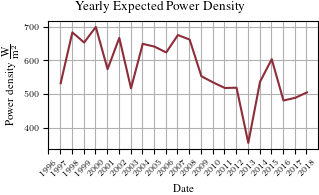

In [24]:
# plot expected values for each year
half_fig()
fig, ax = plt.subplots()
vals = []
for year, year_df in wind_year_dists.groupby("year"):
    if year < 1997: continue
    if year >= 2019: break
    dist = year_df.weibull.values[0]
    integrant = lambda x: expected_density_integrant(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 22)
    vals.append((year, result))

years = list(map(lambda t: dt.datetime(t[0], 1, 15), vals))
e = list(map(lambda t: t[1], vals))

ax.plot(years, e, color=tpc.rgb.tue_red)

ax.xaxis.set_major_locator(mdt.YearLocator())
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2018, 12, 31)))
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
ax.grid()
fig.suptitle("Yearly Expected Power Density")
fig.show()

For the monthly expectated wind power denstiy, we can again observe the pattern of lower wind speeds in the summer.

LinregressResult(slope=-0.022908248150783305, intercept=635.7232545829454, rvalue=-0.1723567634689866, pvalue=0.007571203148193199, stderr=0.008504344752079727, intercept_stderr=35.60173931150111)


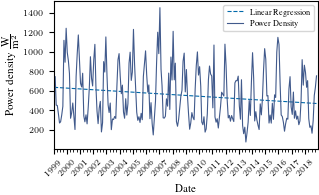

In [32]:
start_y = 1999
start_dt = dt.datetime(start_y, 1, 15)
end_y = 2018 # inclusive
# evaluate monthly
step_size = 1
extrapol_days = 365 * 9

# plot expected values for each month
half_fig()
fig, ax = plt.subplots(1, 1)
vals = []
for (year, month), year_month_df in wind_month_pdfs.groupby(["year", "month"]):
    if year < start_y or year > end_y: continue
    dist = year_month_df.weibull.values[0]
    integrant = lambda x: expected_density_integrant(x, dist)
    result, _ = scipy.integrate.quad(integrant, 3, 20)
    vals.append((year, month, result))
    # vals.append((year, month, year_month_df.pdf.values[0].mean))

months = list(map(lambda t: dt.datetime(t[0], t[1], 15), vals))
e = list(map(lambda t: t[2], vals))

days_delta = np.array(list(map(lambda t: (t - start_dt).days, months)))
lin_reg_res = scipy.stats.linregress(days_delta, e)
print(lin_reg_res)
ax.plot(months, lin_reg_res.slope * days_delta + lin_reg_res.intercept, "--", linewidth=0.8, color=tpc.rgb.tue_blue, label="Linear Regression")
ax.plot(months, e, color=tpc.rgb.tue_darkblue, linewidth=0.8, label="Power Density")
# ax.plot(months, e, ".", markersize=2, color=tpc.rgb.tue_darkblue, label="Power Density")

ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
# ax.xaxis.set_minor_formatter(mdt.DateFormatter("%B"))
ax.tick_params(axis='x', which='minor', rotation=90)
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(start_y, 1, 1), dt.datetime(end_y, 12, 31)))
ax.set_ylabel(r"Power density $\frac{\textrm{W}}{\textrm{m}^2}$")
# ax.grid()
ax.legend()
# fig.suptitle("Monthly Expected Power Density")
fig.savefig(os.path.join(FIGURE_FOLDER, "monthly_exp_pwr_dnsry.pdf"))

# Prediction

Now, we turn to using the expected power density as ground truth for a Gaussian Process Regression model for extrapolation. The first step involves finding a good kernel function `k`. We do this by building our intution/assumptions into the model via the prior. In this case, the data can be easily visualised and we can intuitively make assumption about the latent function from which we assume the data is sampled.

$$\mathcal{GP}(f; 0, k), \quad \mathcal{N}(Y; f, \sigma I), \quad \mathcal{GP}(f; m', k') \propto \mathcal{N}(Y; f, \sigma I) \cdot \mathcal{GP}(f; 0, k)$$

In [33]:
# f is indexed by the time-delta (in days) with respect to the starting year
X = np.array(list(map(lambda d: (d - start_dt).days, months))).reshape(-1, 1)
# The input is expected to be 2d by the library
Y = np.array(e).reshape(-1, 1)
r = range(0, 365 * (end_y - start_y + 1) + extrapol_days, step_size)
x = np.array(r).reshape(-1, 1)
# We will clip the data by 2 years (24 months) to have the remaining data as test data
n_months_cutoff = 24

# TODO Wiener-Kernel?, multiplicative
k1 = 1e-5 * GPK.DotProduct() + GPK.ExpSineSquared(length_scale=1, periodicity=180) + GPK.ExpSineSquared(length_scale=1, periodicity=365) + 0.1 * GPK.RBF(length_scale=30) # * GPK.Matern(length_scale=180, nu=5/2)

# ---
long_term_trend_kernel = 7.5e-6**2 * GPK.DotProduct(Y.max() - Y.min()) ** 2
yearly_trend_kernel = 350**2 * GPK.ExpSineSquared(length_scale=1.15, periodicity=365)
seasonal_kernel = 50**2 * GPK.ExpSineSquared(length_scale=1.5, periodicity=180) * (5e-3**2 * GPK.RBF(length_scale=365))
irregularities_kernel = 1.5e-1 * GPK.RBF(length_scale=30)
k2 = long_term_trend_kernel + seasonal_kernel + irregularities_kernel + yearly_trend_kernel
# ---
# Instead of a linear kernel, we use a _very_ smooth squared-exponential to have a bit more uncertainity about the future behaviour.
long_term_trend_kernel = 100**2 * GPK.RBF(365e3)
# For the periodicity, we use a exponential sine squared kernel multiplied with an smooth squared-exponential to allow for a decaying amplitude.
yearly_trend_kernel = 350**2 * GPK.ExpSineSquared(length_scale=2, periodicity=365) * GPK.RBF(length_scale=365e4)
mid_term_trend = 10**2 * GPK.RationalQuadratic(length_scale=30, alpha=1e-4)
noise_kernel = GPK.WhiteKernel(2e-1) + 1e-1**2 * GPK.Matern(length_scale=1, nu=1/2) #1e-2**2 * GPK.RBF(length_scale=30) # try short length 1/2 matern kernel
k3 = long_term_trend_kernel + yearly_trend_kernel + mid_term_trend + noise_kernel
# ---

gp = GP(kernel=k3, normalize_y=True, optimizer=None, random_state=1)

For building an intuition of how our choice for the kernel behave and to gauge how well our assumption are reflected by the data, we draw samples from the prior distribution. We can observe that the gray sample captures the behaviour of the data quite accurately. We consider this as validating our kernel design.

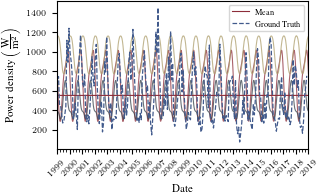

In [34]:
half_fig()
fig, ax = plt.subplots()
sample_steps = 7

x_sample = np.array(range(0, 365 * (end_y + 1 - start_y), sample_steps)).reshape(-1, 1)
# pick nice samples and fix random state for reproducability
samples = gp.sample_y(x_sample, n_samples=3, random_state=2)
pred_mean, pred_std = gp.predict(x_sample, return_std=True)
x_sample_dt = days_to_date(start_dt, x_sample)

# plot mean and samples
ax.plot(x_sample_dt, samples[::-1] + Y.mean(), linewidth=0.8, alpha=0.75)
ax.plot(x_sample_dt, pred_mean + Y.mean(), label="Mean", color=tpc.rgb.tue_red, linewidth=0.8)
ax.plot(months, Y, "--", linewidth=0.9, color=tpc.rgb.tue_darkblue, label="Ground Truth")
# ax.plot(months, Y, ".", markersize=1.5, color=tpc.rgb.tue_darkblue, label="Ground Truth")
# ax.plot(x_sample_dt, pred_mean + Y.mean() + pred_std, color=tpc.rgb.tue_red, linewidth=0.1) 
# ax.plot(x_sample_dt, pred_mean + Y.mean() - pred_std, color=tpc.rgb.tue_red, linewidth=0.1)
# ax.fill_between(x_sample_dt, pred_mean + Y.mean() + pred_std, pred_mean + Y.mean() - pred_std, alpha=0.05, color=tpc.rgb.tue_red, label="std. dev.")
ax.legend(ncols=1)
ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y + 1, 1, 1))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.tick_params(axis='x', which="major", rotation=45)
ax.set_xlabel("Date")
# ax.grid()
ax.set_ylabel(r"Power density $\left(\frac{\textrm{W}}{\textrm{m}^2}\right)$")
# fig.suptitle("Prior Samples")
fig.savefig(os.path.join(FIGURE_FOLDER, "gp_samples.pdf"))

Now comes the actual step of conditioning our GP prior on the data to obtain the posterior distribution. We withhold the last two years of data such that the model is not trained on it. This is important, because we want to use the last two years for validating/testing the prediction done by the model.

In [35]:
gp.fit(X[:-n_months_cutoff], Y[:-n_months_cutoff])
pred_mean, std = gp.predict(x, return_std=True)
samples = gp.sample_y(x_sample, n_samples=5)

By plotting the result together with the ground truth, we can observe a gradual increase of the standard deviation (uncertainity) the further the model extrapolates into the future. Also, we can note that the model is not overfitting on some of the more extreme values. Additionally, most of these are well within one standard deviation of the mean which supports the uncertainity quantification of the model.

100**2 * RBF(length_scale=3.65e+05) + 350**2 * ExpSineSquared(length_scale=2, periodicity=365) * RBF(length_scale=3.65e+06) + 10**2 * RationalQuadratic(alpha=0.0001, length_scale=30) + WhiteKernel(noise_level=0.2) + 0.1**2 * Matern(length_scale=1, nu=0.5)

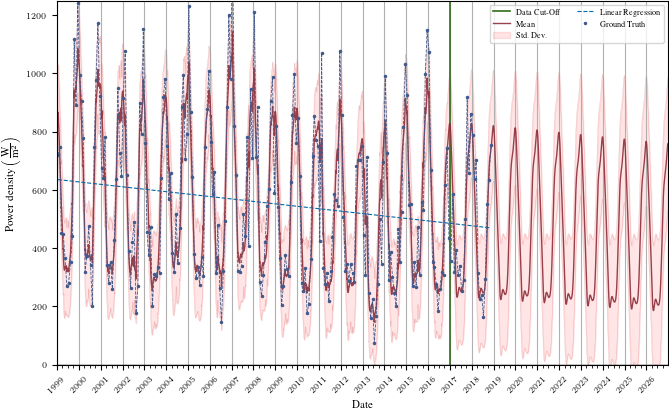

In [37]:
x_dt = days_to_date(start_dt, x)
X_dt = days_to_date(start_dt, X)

full_fig()
fig, ax = plt.subplots()

ax.axvline(dt.datetime(end_y + 1 - n_months_cutoff // 12, 1, 1), color=tpc.rgb.tue_darkgreen, linewidth=1.2, label="Data Cut-Off")
ax.axhline(0, color="black", linewidth=1)

# ax.plot(x_sample_dt, samples, alpha=0.5, color=tpc.rgb.tue_gray, linewidth=0.1)
ax.plot(x_dt, pred_mean, "-", linewidth=1, label="Mean", color=tpc.rgb.tue_red, alpha=0.9)
ax.plot(x_dt, pred_mean + std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.plot(x_dt, pred_mean - std, "-", alpha=0.25, color=tpc.rgb.tue_red, linewidth=0.2)
ax.fill_between(x_dt, pred_mean + std, pred_mean - std, color="red", alpha=0.1, label="Std. Dev.")

ax.plot(months, lin_reg_res.slope * days_delta + lin_reg_res.intercept, "--", linewidth=0.8, color=tpc.rgb.tue_blue, label="Linear Regression")

ax.plot(X_dt, Y, "--", color=tpc.rgb.tue_darkblue, linewidth=0.6)
ax.plot(X_dt, Y, ".", label="Ground Truth", markersize=3, color=tpc.rgb.tue_darkblue)

ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y, 1, 1) + dt.timedelta(extrapol_days))
ax.set_ylim(0, 1250)
ax.set_ylabel(r"Power density $\left(\frac{\textrm{W}}{\textrm{m}^2}\right)$")
ax.set_xlabel("Date")
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.legend(ncols=2)
ax.tick_params(axis='x', which="major", rotation=45)
ax.xaxis.grid()
# fig.suptitle("Monthly Expected Power Density")
plt.savefig(os.path.join(FIGURE_FOLDER, "gp_pred.pdf"))
gp.kernel_